# Results wPCC VCT

In [213]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys, plot_VCT_components

import paper
from phd.visualization.styles import styles
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from sklearn.metrics import mean_squared_error, r2_score
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
import matplotlib.patches as mpatches 

In [215]:
ship_name = "wPCC"

In [236]:
#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder").items()}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']
loaders.pop('polynomial rudder complex')  # for now...

[11/22/24 16:22:15] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder'              ]8;id=65842;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=660293;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT' (PartitionedDataset)...        ]8;id=867420;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=358438;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<bound method AbstractDataset.load of <phd.extras.datasets.model_dataset.ModularVesselSimulatorDataSet object at 0x7f62f231f8b0>>

In [237]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [238]:
model = models['polynomial rudder simple']

In [239]:
#df_VCT = catalog.load(f"{ship_name}.df_VCT_all_raw")['M5139-02-A_MS.df_VCT']()
#(df_VCT['fx'] - df_VCT['fx_rudders'] - df_VCT['fx_hull'] - model.parameters['Xthrustport']*df_VCT['thrust'])

In [240]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")

[11/22/24 16:22:20] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=226233;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350300;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [241]:
assert ((df_VCT['Y_D'] - df_VCT['Y_R'] - df_VCT['Y_H']).abs() < 10**-10).all()
assert ((df_VCT['N_D'] - df_VCT['N_R'] - df_VCT['N_H']).abs() < 10**-10).all()
assert ((df_VCT['X_D'] - df_VCT['X_R'] - df_VCT['X_P'] - df_VCT['X_H']).abs() < 10**-10).all()

In [242]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
mask = df_VCT['V'] > 0.9
df_VCT = df_VCT.loc[mask].copy()
df_VCT = add_mirrored(df_VCT)
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=45893;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=381598;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [243]:
df_prediction = predict(model=model, data=df_VCT)
df_prediction['Y_H']+=df_prediction['Y_RHI']
df_prediction['N_H']+=df_prediction['N_RHI']



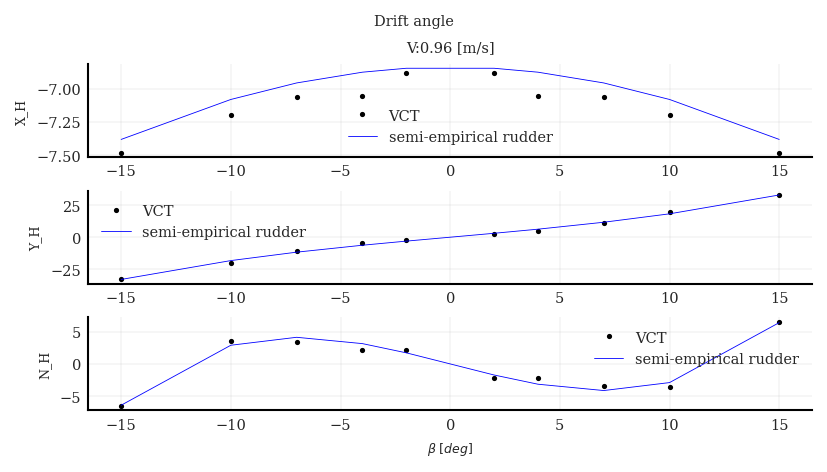

In [244]:
predictions = {
    "semiempirical rudder" : df_prediction,
}

plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys = ['X_H', 'Y_H', 'N_H'], test_type='Drift angle', styles=styles);

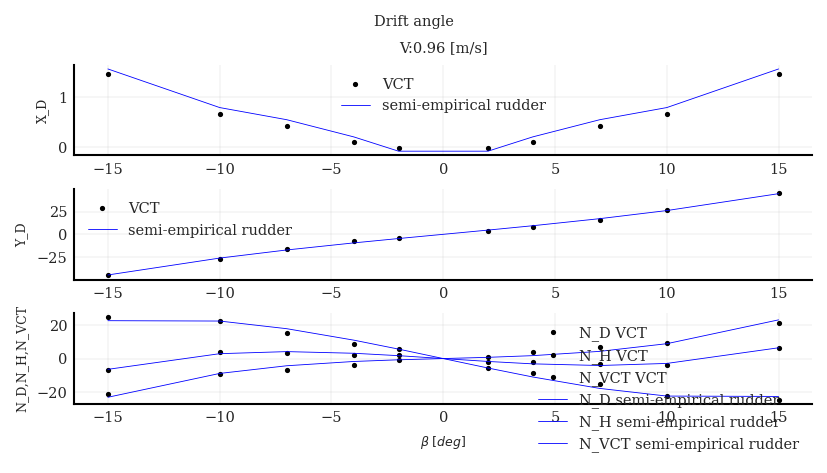

In [245]:
plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys=['X_D', 'Y_D', ['N_D','N_H','N_VCT']], test_type='Drift angle', styles=styles);

In [246]:
#df_VCT['X_P'] = df_VCT['thrust']

In [247]:
#df_prediction['X_H']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [248]:
#df_prediction['X_D']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [249]:
model.subsystems['hull'].equations['X_H']

Eq(X_H, X_{0} + X_{rr}*r**2 + X_{u}*u + X_{vr}*r*v + X_{vv}*v**2)

In [250]:
color_palette = ['k','c','r','m']
colors={}
for dof in ['X','Y','N']:
    color_all = color_palette.copy()
    for subscript in ['D','H','R','P']:
        key = f"{dof}_{subscript}"
        colors[key] = color_all.pop(0)
        

In [251]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

[11/22/24 16:22:22] WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=886573;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=948262;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=481630;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=907151;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=196412;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=127756;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=434710;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=353887;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=714944;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=718159;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=556539;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=45932;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=472747;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=648690;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=255432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=973318;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=423383;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=942525;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=329381;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=474394;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=960350;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=17490;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

[11/22/24 16:22:23] WARNING  /tmp/ipykernel_76547/1332953671.py:33: MatplotlibDeprecationWarning:   ]8;id=396674;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=807027;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.50, 1.15), ncol=4)                                                  
                                                                                                                   

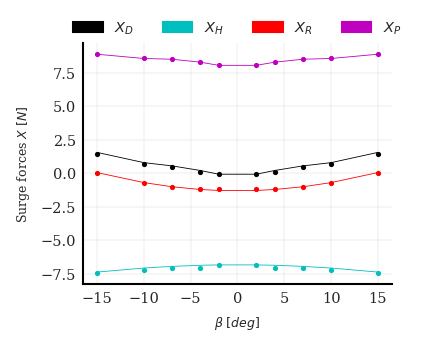

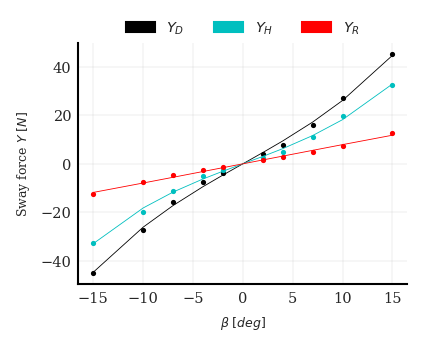

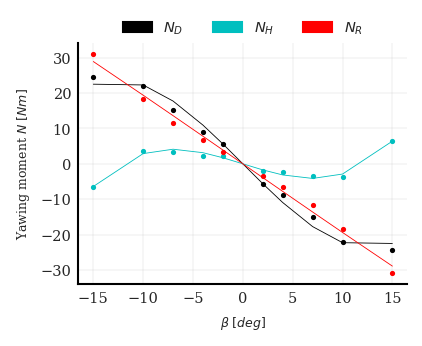

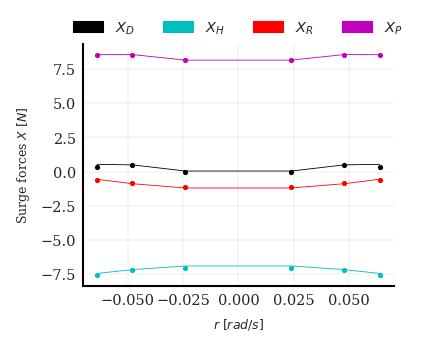

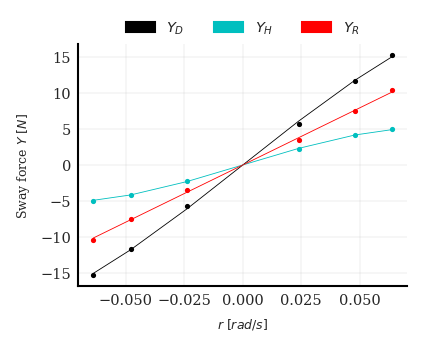

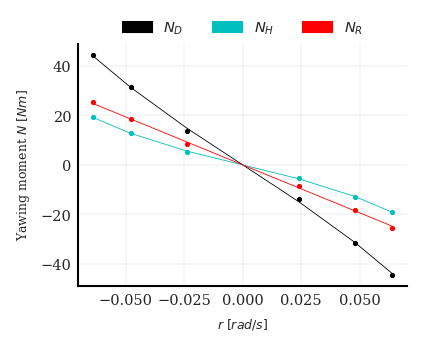

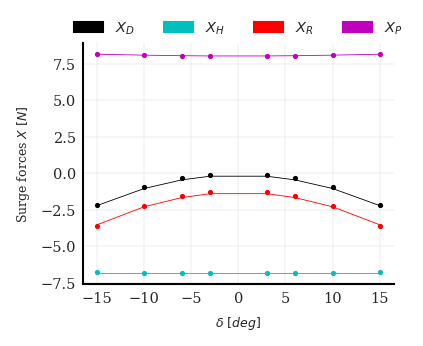

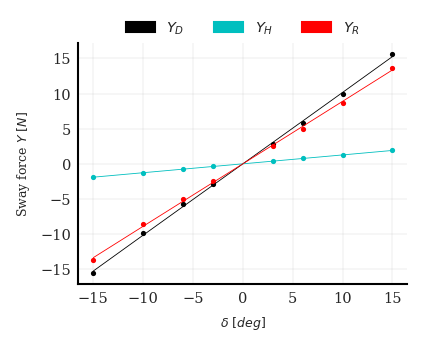

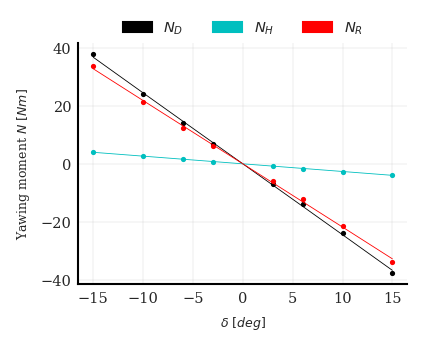

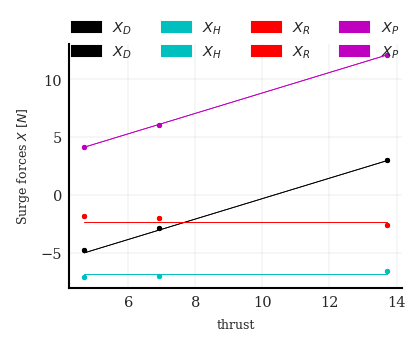

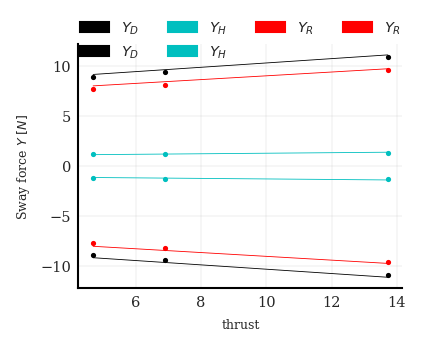

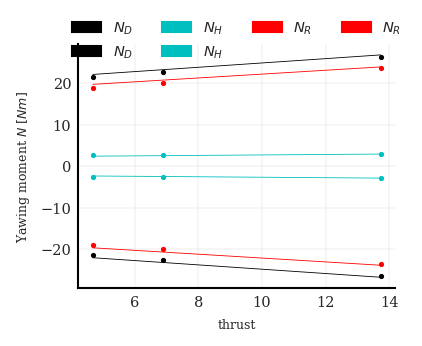

In [252]:

dofs={
    'X':{
        'y_label':r'Surge forces $X$ $[N]$',
        'y_keys':['X_D','X_H','X_R','X_P'],
    },
    'Y':{
        'y_label':r'Sway force $Y$ $[N]$',
        'y_keys':['Y_D','Y_H','Y_R'],
    },
    'N':{
        'y_label':r'Yawing moment $N$ $[Nm]$',
        'y_keys':['N_D','N_H','N_R'],
    },
    
}

test_types = [
    'Drift angle',
    'Circle',
    'Rudder angle',
    'Thrust variation',
             ]

for test_type in test_types:
    for dof, meta_data in dofs.items():
    
        fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[meta_data['y_keys'],], test_type=test_type, 
                            colors=colors);
        #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.05), ncol=4)
        labels = [line.get_label() for line in fig.axes[0].lines]
        colors_ = [line.get_color() for line in fig.axes[0].lines]
        patches = [mpatches.Patch(color=colors_[i], label=label) for i,label in enumerate(labels)]
        fig.axes[0].legend(handles=patches, loc='upper center', bbox_to_anchor=(0.50, 1.15), ncol=4)
        
        fig.axes[0].set_ylabel(meta_data['y_label'])
        fig.set_size_inches(paper.figure_width/2, paper.figure_height*0.75)
        fig.suptitle('')
        fig.axes[0].set_title('')
        file_name = test_type.lower().replace(' ','_')
        #paper.save_fig(fig,f"{file_name}.svg")

In [253]:
#mask = ((df_VCT['delta'] == 0))
#df = df_VCT.loc[mask]
df = df_VCT.groupby('test type').get_group('Circle + Drift')
df = df.groupby('r').filter(lambda x:len(x) > 1)

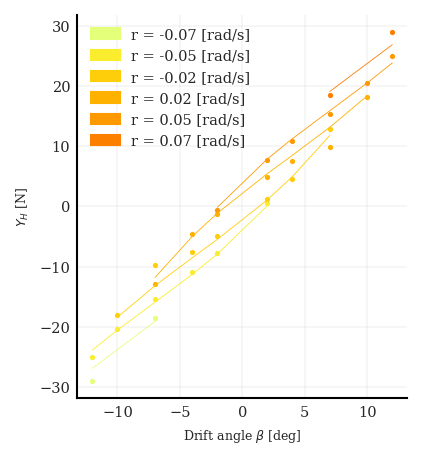

In [254]:
fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['Y_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]

fig.axes[0].legend(labels, handles=patches)
fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$Y_H$ [N]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_Y_H.svg")

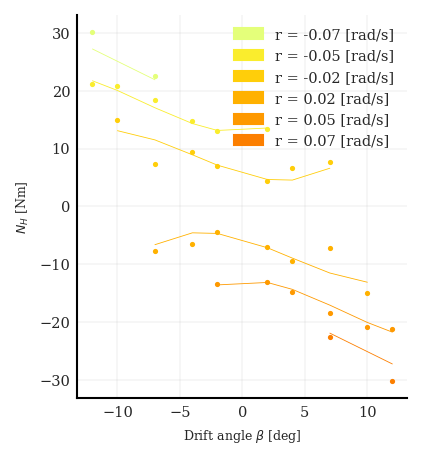

In [255]:

fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['N_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]
fig.axes[0].legend(labels, handles=patches)

fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$N_H$ [Nm]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_N_H.svg")